<a href="https://colab.research.google.com/github/rfaoktvian/AnalisisSentimenDebatCapres2024/blob/main/Analisis_sentimen_debat_capres2024.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!pip install Sastrawi

In [5]:
import os, csv, requests, re, nltk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from io import StringIO
from googleapiclient.discovery import build
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

# Deep Learning Libraries
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, GRU
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [6]:
df = pd.read_csv('youtube_comments_debat_capres2024.csv')
df.head(100)

,comment_text,like_count,reply_count,published_at
0,Menjatuhkan kinerja seseorg dipublik sama dgñ ...,1,0,2026-01-21T17:42:14Z
1,Aku terbangun jam 2 mlm tiba2 ingat debat ini,1,0,2026-01-15T19:17:31Z
2,this year everything is proven,2,0,2026-01-14T05:12:17Z
3,"gua balik lagi kesini, gara gara konoha mulai ...",12,2,2025-12-20T16:19:49Z
4,Hanya Pak Anis yg bahas isu lingkungan di deba...,4,0,2025-12-14T12:47:20Z
...,...,...,...,...
95,"Kayak nyari"" kesalahan",0,0,2024-02-17T14:35:40Z
96,Ini Anis parah banget terlalu menyerang pribad...,0,0,2024-02-17T14:30:53Z
97,Flash back liat debat presiden ini\n01 & 03 pr...,0,0,2024-02-17T14:28:24Z
98,"Ini Anis ngapain nanyak pribadi ya ,kampret bnget",0,0,2024-02-17T12:30:33Z


In [7]:
df.shape

(10930, 4)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10930 entries, 0 to 10929
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   comment_text  10930 non-null  object
 1   like_count    10930 non-null  int64 
 2   reply_count   10930 non-null  int64 
 3   published_at  10930 non-null  object
dtypes: int64(2), object(2)
memory usage: 341.7+ KB


In [9]:
clean_df = df.drop_duplicates()

In [10]:
clean_df.duplicated().sum()

np.int64(0)

In [11]:
# Text Preprocessing

def cleaningText(text):
  text = re.sub(r'@[A-Za-z0-9]+', '', text)
  text = re.sub(r'#[A-Za-z0-9]+', '', text)
  text = re.sub(r'RT[\s]', '', text)
  text = re.sub(r"http\S+", '', text)
  text = re.sub(r'[0-9]+', '', text)
  text = re.sub(r'[^\w\s]', '', text)
  text = text.replace('\n', ' ')
  text = text.strip(' ')
  return text

slangwords = {
    "abis": "habis",
    "bgt": "banget",
    "bangettt": "banget",
    "bgtt": "banget",
    "gk": "tidak",
    "ga": "tidak",
    "gak": "tidak",
    "nggak": "tidak",
    "enggak": "tidak",
    "tdk": "tidak",
    "dr": "dari",
    "dri": "dari",
    "aja": "saja",
    "udh": "sudah",
    "udah": "sudah",
    "blm": "belum",
    "belom": "belum",
    "pdhl": "padahal",
    "krn": "karena",
    "sm": "sama",
    "jg": "juga",
    "tp": "tapi",
    "trs": "terus",
    "org": "orang",
    "kmrn": "kemarin",
    "skrg": "sekarang",
    "omon": "bicara",
    "sory": "sorry",
    "sori": "sorry",
    "anis": "anies",
    "kren": "keren",
    "sy": "saya",
    "sya": "saya",
    "nnti": "nanti",
    "yg": "yang",
    "dgn": "dengan",
    "sdh": "sudah",
    "pd": "pada",
    "bs": "bisa",
    "klo": "kalau",
    "kalo": "kalau",
    "kl": "kalau",
    "msh": "masih",
    "lg": "lagi",
    "jd": "jadi",
    "nih": "ini",
    "tuh": "itu",
    "kyk": "seperti",
    "kayak": "seperti",
    "gw": "saya",
    "gua": "saya",
    "lu": "kamu",
    "lo": "kamu",
    "tau": "tahu",
    "cm": "cuma",
    "dlm": "dalam",
    "gemoy": "gemas",
    "ny": "nya",
    "anie": "anies",
    "mani": "manis",
    "utk": "untuk",
    "pa": "bapak",
    "p": "bapak",
    "tpi": "tapi",
    "dah": "sudah",
    "jgn": "jangan",
    "bpk": "bapak",
    "karna": "karena",
    "pinter": "pintar",
    "capre": "capres",
    "liat": "lihat",
    "jdi": "jadi",
    "kali": "mungkin",
    "bagu": "bagus",
    "pk": "pak",
    "ni": "ini",
    "g" : "tidak",



}
def fix_slangwords(text):
    words = text.split()
    fixed_words = []

    for word in words:
        if word in slangwords:
            fixed_words.append(slangwords[word])
        else:
            fixed_words.append(word)

    return " ".join(fixed_words)

def casefoldingText(text):
    text = text.lower()
    return text

def tokenizingText(text):
    text = word_tokenize(text)
    return text

def filteringText(tokens):
    stop_id = set(stopwords.words('indonesian'))
    stop_en = set(stopwords.words('english'))

    negation_words = {"tidak", "bukan", "jangan", "nggak", "enggak"}

    stopwords_all = (stop_id | stop_en) - negation_words

    custom_stopwords = {
        "iya","yaa","sih","loh","kah","woi","woii","woy",
        "nya","ku","di","ke","dari"
    }

    stopwords_all.update(custom_stopwords)

    return [word for word in tokens if word not in stopwords_all]

def toSentence(list_words): # Mengubah daftar kata menjadi kalimat
    sentence = ' '.join(word for word in list_words)
    return sentence

factory = StemmerFactory()
stemmer = factory.create_stemmer()

def stemmingText(text):
    return stemmer.stem(text)


In [12]:

nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

def preprocess_wrapper(text):
    if not isinstance(text, str):
        return ""

    text = cleaningText(text)
    text = casefoldingText(text)
    text = fix_slangwords(text)
    tokens = tokenizingText(text)
    tokens = filteringText(tokens)
    sentence = toSentence(tokens)
    # Stemming opsional: aktifkan jika butuh akurasi lebih tapi siap menunggu lama
    # sentence = stemmingText(sentence)
    return sentence

clean_df['final_text'] = clean_df['comment_text'].apply(preprocess_wrapper)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
/tmp/ipython-input-703599033.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_df['final_text'] = clean_df['comment_text'].apply(preprocess_wrapper)


In [13]:
print(clean_df[['comment_text', 'final_text']].head())

                                        comment_text  \
0  Menjatuhkan kinerja seseorg dipublik sama dgñ ...   
1      Aku terbangun jam 2 mlm tiba2 ingat debat ini   
2                     this year everything is proven   
3  gua balik lagi kesini, gara gara konoha mulai ...   
4  Hanya Pak Anis yg bahas isu lingkungan di deba...   

                                          final_text  
0  menjatuhkan kinerja seseorg dipublik dgñ menja...  
1                            terbangun jam mlm debat  
2                             year everything proven  
3          kesini gara gara konoha hancur berantakan  
4  anies bahas isu lingkungan debat capres haya t...  


In [14]:
from io import StringIO


lexicon_positive = dict()

response = requests.get('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_positive.csv')


if response.status_code == 200:
    reader = csv.reader(StringIO(response.text), delimiter=',')

    for row in reader:
        lexicon_positive[row[0]] = int(row[1])
else:
    print("Failed to fetch positive lexicon data")

lexicon_negative = dict()

response = requests.get('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_negative.csv')

if response.status_code == 200:
    reader = csv.reader(StringIO(response.text), delimiter=',')
    for row in reader:
        lexicon_negative[row[0]] = int(row[1])
else:
    print("Failed to fetch negative lexicon data")

In [15]:
def sentiment_analysis_lexicon_indonesia(text):
    score = 0

    for word in text.split():
        if word in lexicon_positive:
            score += lexicon_positive[word]
        elif word in lexicon_negative:
            score += lexicon_negative[word]

    if score > 0:
        polarity = "positive"
    elif score < 0:
        polarity = "negative"
    else:
        polarity = "neutral"

    return score, polarity

In [16]:
results = clean_df['final_text'].apply(sentiment_analysis_lexicon_indonesia)
results = list(zip(*results))
clean_df['polarity_score'] = results[0]
clean_df['polarity'] = results[1]

/tmp/ipython-input-2166883952.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_df['polarity_score'] = results[0]
/tmp/ipython-input-2166883952.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_df['polarity'] = results[1]


In [17]:
print(clean_df['polarity'].value_counts())
print(clean_df['polarity'].value_counts(normalize=True))


polarity
positive    5333
negative    3141
neutral     2447
Name: count, dtype: int64
polarity
positive    0.488325
negative    0.287611
neutral     0.224064
Name: proportion, dtype: float64


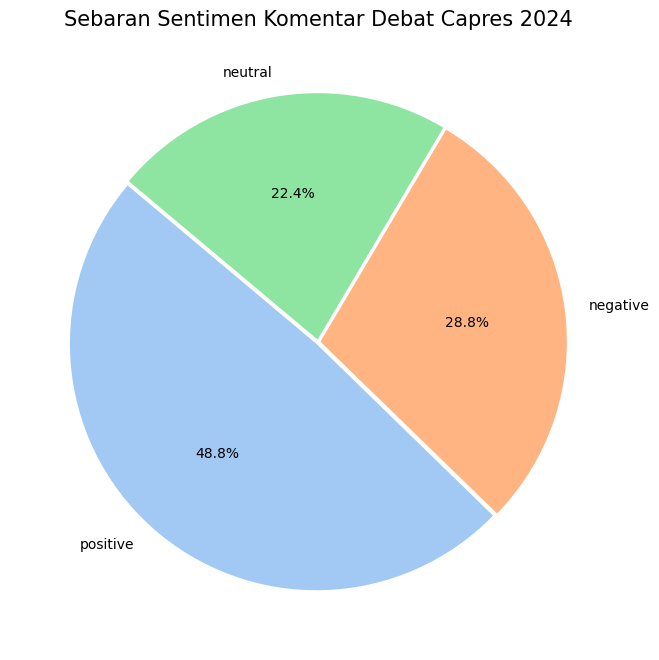

Jumlah Komentar Per Kategori:
polarity
positive    5333
negative    3141
neutral     2447
Name: count, dtype: int64


In [18]:
sentiment_counts = clean_df['polarity'].value_counts()

colors = ['#66b3ff', '#99ff99', '#ff9999']
plt.figure(figsize=(8, 8))
plt.pie(
    sentiment_counts,
    labels=sentiment_counts.index,
    autopct='%1.1f%%',
    startangle=140,
    colors=sns.color_palette('pastel'),
    explode=(0.01, 0.01, 0.01)
)
plt.title('Sebaran Sentimen Komentar Debat Capres 2024', fontsize=15)
plt.show()
print("Jumlah Komentar Per Kategori:")
print(sentiment_counts)

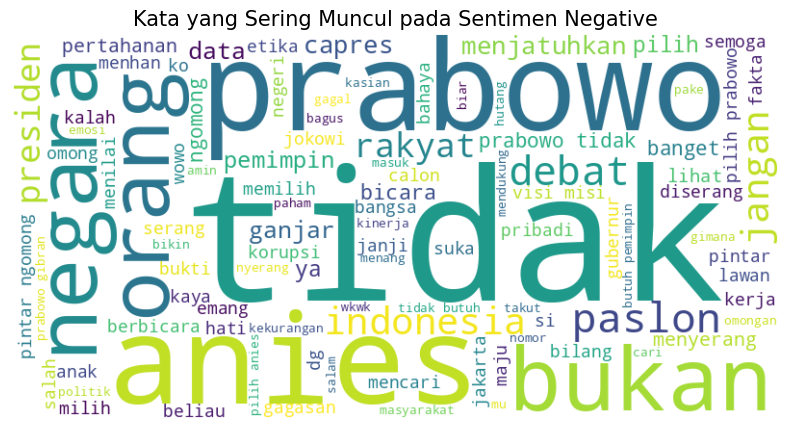

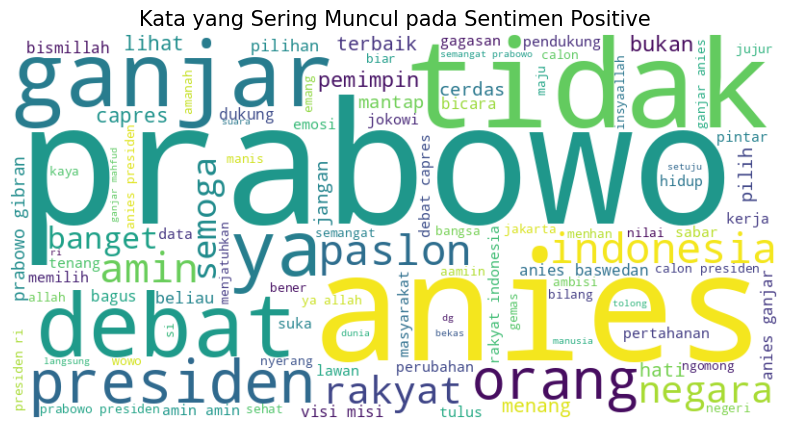

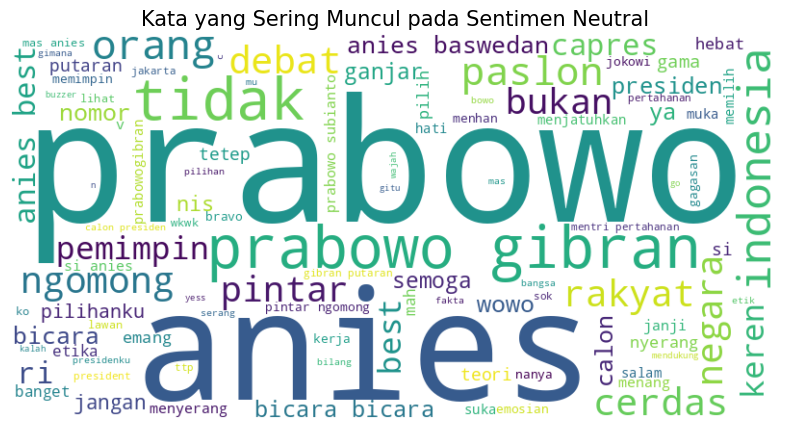

In [19]:
from wordcloud import WordCloud

def show_wordcloud(sentiment):

    text = " ".join(clean_df[clean_df['polarity'] == sentiment]['final_text'])

    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='white',
        colormap='viridis',
        max_words=100
    ).generate(text)


    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Kata yang Sering Muncul pada Sentimen {sentiment.capitalize()}', fontsize=15)
    plt.axis('off')
    plt.show()


for label in clean_df['polarity'].unique():
    show_wordcloud(label)

In [20]:
X_text = clean_df['final_text']
y_label = clean_df['polarity']

In [21]:
X_train_ml, X_test_ml, y_train_ml, y_test_ml = train_test_split(
    X_text,
    y_label,
    test_size=0.2,
    random_state=42,
    stratify=y_label
)

In [22]:
tfidf = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1,2)
)

X_train_tfidf = tfidf.fit_transform(X_train_ml)
X_test_tfidf  = tfidf.transform(X_test_ml)

In [24]:
model4 = MultinomialNB()
model4.fit(X_train_tfidf, y_train_ml)

y_pred = model4.predict(X_test_tfidf)
accuracy = accuracy_score(y_test_ml, y_pred)
print("Test Accuracy Model Naive Bayes:", accuracy)

Test Accuracy Model Naive Bayes: 0.6919908466819222


In [25]:
# 1. Mengubah Label ke Angka (Negative:0, Neutral:1, Positive:2)
le = LabelEncoder()
y_encoded = le.fit_transform(clean_df['polarity'])

In [26]:
# 2. Tokenisasi Teks
max_words = 5000
tokenizer = Tokenizer(num_words=max_words, split=' ')
tokenizer.fit_on_texts(clean_df['final_text'].values)

X_seq = tokenizer.texts_to_sequences(clean_df['final_text'].values)

In [27]:
# 3. Padding (Menyamakan panjang kalimat)
max_len = 100
X_pad = pad_sequences(X_seq, maxlen=max_len)

In [28]:
# 4. Split Data
X_train, X_temp, y_train, y_temp = train_test_split(
    X_pad, y_encoded,
    test_size=0.3,
    random_state=42,
    stratify=y_encoded
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.5,
    random_state=42,
    stratify=y_temp
)

In [29]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=2,
    restore_best_weights=True
)

In [30]:
model1 = Sequential([
    Embedding(max_words, 128, input_length=max_len),
    Bidirectional(LSTM(64)),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

model1.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
print("Memulai Training Skema 1...")
history1 = model1.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stop],
    verbose=1
)

Memulai Training Skema 1...
Epoch 1/10


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


239/239 ━━━━━━━━━━━━━━━━━━━━ 39s 143ms/step - accuracy: 0.5721 - loss: 0.8902 - val_accuracy: 0.8120 - val_loss: 0.4877
Epoch 2/10
239/239 ━━━━━━━━━━━━━━━━━━━━ 38s 133ms/step - accuracy: 0.8773 - loss: 0.3331 - val_accuracy: 0.8437 - val_loss: 0.4339
Epoch 3/10
239/239 ━━━━━━━━━━━━━━━━━━━━ 29s 121ms/step - accuracy: 0.9405 - loss: 0.1800 - val_accuracy: 0.8504 - val_loss: 0.4490
Epoch 4/10
239/239 ━━━━━━━━━━━━━━━━━━━━ 32s 132ms/step - accuracy: 0.9622 - loss: 0.1308 - val_accuracy: 0.8480 - val_loss: 0.5784


In [31]:
model2 = Sequential([
    Embedding(max_words, 128, input_length=max_len),
    Bidirectional(LSTM(64, return_sequences=True)),
    Bidirectional(LSTM(32)),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

model2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
print("Memulai Training Skema 2...")
history2 = model2.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stop],
    verbose=1
)

Memulai Training Skema 2...
Epoch 1/10
239/239 ━━━━━━━━━━━━━━━━━━━━ 65s 213ms/step - accuracy: 0.5669 - loss: 0.8960 - val_accuracy: 0.7882 - val_loss: 0.5263
Epoch 2/10
239/239 ━━━━━━━━━━━━━━━━━━━━ 80s 206ms/step - accuracy: 0.8822 - loss: 0.3621 - val_accuracy: 0.8181 - val_loss: 0.4887
Epoch 3/10
239/239 ━━━━━━━━━━━━━━━━━━━━ 50s 209ms/step - accuracy: 0.9353 - loss: 0.2109 - val_accuracy: 0.8309 - val_loss: 0.5215
Epoch 4/10
239/239 ━━━━━━━━━━━━━━━━━━━━ 50s 209ms/step - accuracy: 0.9433 - loss: 0.1857 - val_accuracy: 0.8315 - val_loss: 0.5177


In [32]:
model3 = Sequential([
    Embedding(max_words, 256, input_length=max_len), # Ukuran embedding lebih besar
    Bidirectional(LSTM(128)),
    Dense(64, activation='relu'), # Lapisan tambahan untuk ekstraksi fitur
    Dropout(0.3),
    Dense(3, activation='softmax')
])

model3.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
print("Memulai Training Skema 3...")
history3 = model3.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stop],
    verbose=1
)

Memulai Training Skema 3...
Epoch 1/10
239/239 ━━━━━━━━━━━━━━━━━━━━ 109s 435ms/step - accuracy: 0.6299 - loss: 0.8033 - val_accuracy: 0.8156 - val_loss: 0.4776
Epoch 2/10
239/239 ━━━━━━━━━━━━━━━━━━━━ 142s 434ms/step - accuracy: 0.9018 - loss: 0.2858 - val_accuracy: 0.8413 - val_loss: 0.4200
Epoch 3/10
239/239 ━━━━━━━━━━━━━━━━━━━━ 103s 433ms/step - accuracy: 0.9555 - loss: 0.1530 - val_accuracy: 0.8455 - val_loss: 0.5105
Epoch 4/10
239/239 ━━━━━━━━━━━━━━━━━━━━ 105s 438ms/step - accuracy: 0.9656 - loss: 0.1194 - val_accuracy: 0.8431 - val_loss: 0.6014


In [33]:
test_loss, test_acc = model1.evaluate(X_test, y_test)
print("Test Accuracy Model 1:", test_acc)

test_loss, test_acc = model2.evaluate(X_test, y_test)
print("Test Accuracy Model 2:", test_acc)

test_loss, test_acc = model3.evaluate(X_test, y_test)
print("Test Accuracy Model 3:", test_acc)


52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.8769 - loss: 0.3653
Test Accuracy Model 1: 0.8669920563697815
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.8630 - loss: 0.3911
Test Accuracy Model 2: 0.8468578457832336
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 98ms/step - accuracy: 0.8868 - loss: 0.3297
Test Accuracy Model 3: 0.8743135929107666


In [34]:
def predict_sentiment(text):
    new_text = preprocess_wrapper(text)
    new_seq = tokenizer.texts_to_sequences([new_text])
    new_pad = pad_sequences(new_seq, maxlen=max_len)
    prediction = model3.predict(new_pad)
    return le.inverse_transform([np.argmax(prediction)])

print(predict_sentiment("Pak Prabowo dan Pak Anies debatnya sangat seru dan edukatif!"))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 500ms/step
['positive']
